In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt 
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

###### Add new time related features and delete useless ones

In [ ]:
data = pd.read_csv('data_v3_addtext.csv')
data.created = data.created.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['created_iso_yr'] = data.created.map(lambda x: x.date().isocalendar()[0])
data['created_mo'] = data.created.map(lambda x: x.date().month)
data['created_mo_day'] = data.created.map(lambda x: x.date().day)
data['created_iso_wk'] = data.created.map(lambda x: x.date().isocalendar()[1])
data['date'] = data.created.map(lambda x: x.date())

In [ ]:
useless_cols = ['aid', 'author', 'bvid', 'created', 
                'follower', 'likes', 'play',
                'description', 'title', 'typeid',
                'top1','top2','top3',
                'top1_count', 'top2_count', 'top3_count','count_sum',
                "comment", "video_review"
               ]
data = data.drop(useless_cols, axis = 1)

###### Parameters setting

In [ ]:
cut_off_date = date(2020,8,15)

###### Split Train + Cross Valid, VS Test

In [ ]:
test_idx = data.date > cut_off_date
print('testing percentage:{:.3f}'.format((test_idx).sum() / len(data.date)))
data.drop('date', axis = 1, inplace = True)

testing percentage:0.177


###### Normalization

In [ ]:
file_clean = pd.DataFrame()
for col in data.columns:
    if(col == "log_play"):
        file_clean[col] = data[col].values
    else:
        file_clean[col] = preprocessing.scale(data[col])

In [ ]:
test_df = file_clean[test_idx == True]
train_df = file_clean[test_idx == False]

x_train = train_df.drop(columns = "log_play")
x_test = test_df.drop(columns = "log_play")
y_train = train_df["log_play"]
y_test = test_df["log_play"]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12644, 310), (2728, 310), (12644,), (2728,))

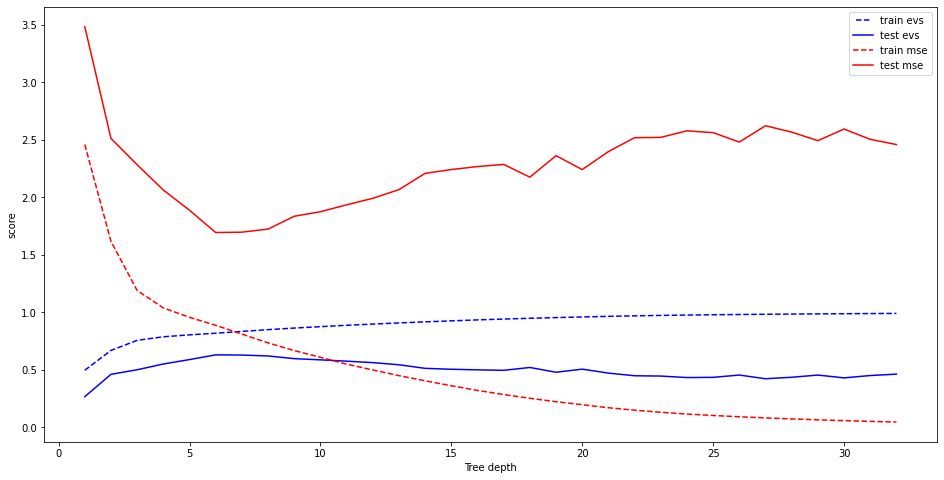

best depth is 6.0 with mse 1.694658842563116 and R2 0.6301177993449971


In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_evs = []
train_mse = []
test_evs = []
test_mse = []
best_depth = -1
best_mse = 999
best_evs = 999
for max_depth in max_depths:
   dt1 = DecisionTreeRegressor(max_depth=max_depth)
   dt1.fit(x_train, y_train)
   train_pred = dt1.predict(x_train)
   evs_train = explained_variance_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   train_evs.append(evs_train)
   train_mse.append(mse_train)
   y_pred = dt1.predict(x_test)
   evs_test = explained_variance_score(y_test, y_pred)
   mse_test = mean_squared_error(y_test, y_pred)
   test_evs.append(evs_test)
   test_mse.append(mse_test)
   if mse_test < best_mse:
       best_mse = mse_test
       best_depth = max_depth
       best_evs = evs_test
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(16,8))
line1, = plt.plot(max_depths, train_evs, '--b', label="train evs")
line2, = plt.plot(max_depths, test_evs, '-b', label="test evs")
line3, = plt.plot(max_depths, train_mse, '--r', label="train mse")
line4, = plt.plot(max_depths, test_mse, '-r', label="test mse")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('Tree depth')
plt.show()
print("best depth is "+str(best_depth)+" with mse "+str(best_mse)+" and R2 "+str(best_evs))

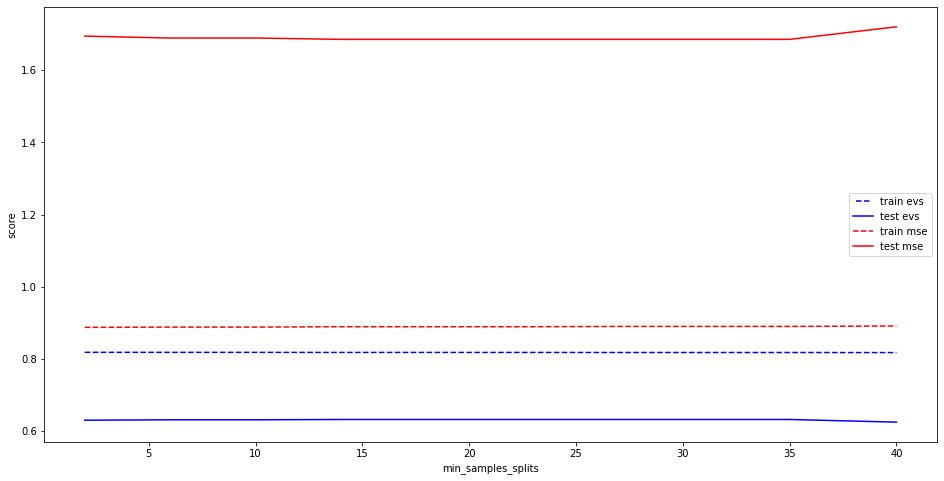

best min_samples_split is 18 with mse 1.6856767392784235 and R2 0.632117374685212


In [ ]:
min_samples_splits = np.linspace(2, 40, 10, dtype = int)
train_evs = []
train_mse = []
test_evs = []
test_mse = []
best_min_samples_split = -1
best_mse = 999
best_evs = 999
for min_samples_split in min_samples_splits:
   dt2 = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=min_samples_split)
   dt2.fit(x_train, y_train)
   train_pred = dt2.predict(x_train)
   evs_train = explained_variance_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   train_evs.append(evs_train)
   train_mse.append(mse_train)
   y_pred = dt2.predict(x_test)
   evs_test = explained_variance_score(y_test, y_pred)
   mse_test = mean_squared_error(y_test, y_pred)
   test_evs.append(evs_test)
   test_mse.append(mse_test)
   if mse_test < best_mse:
       best_min_samples_split = min_samples_split
       best_mse = mse_test
       best_evs = evs_test
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(16,8))
line1, = plt.plot(min_samples_splits, train_evs, '--b', label="train evs")
line2, = plt.plot(min_samples_splits, test_evs, '-b', label="test evs")
line3, = plt.plot(min_samples_splits, train_mse, '--r', label="train mse")
line4, = plt.plot(min_samples_splits, test_mse, '-r', label="test mse")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('min_samples_splits')
plt.show()
print("best min_samples_split is "+str(best_min_samples_split)+" with mse "+str(best_mse)+" and R2 "+str(best_evs))

In [ ]:
dt3 = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=best_min_samples_split)
dt3.fit(x_train, y_train)

y_pred = dt3.predict(x_test)
explained_variance_score(y_test, y_pred)

0.6321173746852118

In [ ]:
file_fi = pd.DataFrame({'importance_value': dt3.feature_importances_}, index=x_train.columns).sort_values(by='importance_value', ascending=False)
file_fi[:20]

,importance_value
last_3month_play,0.967042
length,0.010487
food_ratio,0.003964
life_ratio,0.003453
created_iso_wk,0.001457
similiar_desc陕西,0.001401
similiar_desc吃货,0.001362
last_3month_count,0.001173
similiar_title油炸,0.001016
similiar_desc放入,0.001005


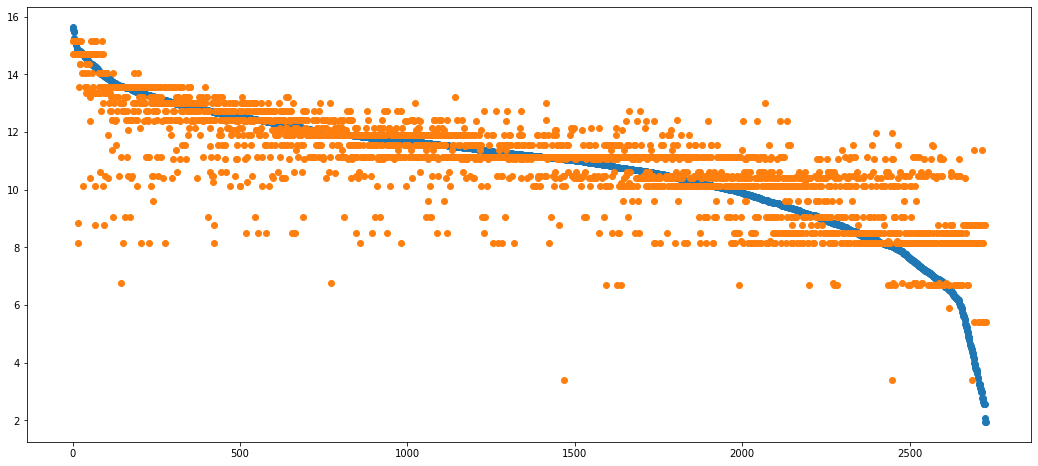

In [ ]:
file_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).sort_values(by='y_test', ascending=False)
plt.figure(figsize=(18,8))
plt.scatter(range(file_pred.shape[0]), file_pred.y_test)
plt.scatter(range(file_pred.shape[0]), file_pred.y_pred)